# Monte Carlo class usage

Finally the Monte Carlo simulations can be performed using a dedicated class called `MonteCarlo`.
Say goodbye to the long and tedious process of creating the Monte Carlo Simulations throughout jupyter notebooks.


In [1]:
# We import these lines for debugging purposes, only works on Jupyter Notebook
%load_ext autoreload
%autoreload 2

First, let's import the necessary libraries, including the newest `MonteCarlo` class!


In [2]:
from rocketpy import Environment, SolidMotor, Rocket, Flight, MonteCarlo, Function
from rocketpy.stochastic import (
    StochasticEnvironment,
    StochasticSolidMotor,
    StochasticRocket,
    StochasticFlight,
    StochasticNoseCone,
    StochasticTail,
    StochasticTrapezoidalFins,
    StochasticParachute,
    StochasticRailButtons,
)
import datetime

If you are using Jupyter Notebooks, it is recommended to run the following line to make matplotlib plots which will be shown later interactive and higher quality.


In [3]:
%matplotlib inline

The `MonteCarlo` class simplifies the process of performing Monte Carlo simulations.
To use it, you simply create an instance of the class and call the `simulate()` method to run the simulations.

This class offers extensive capabilities, and this example covers as many as possible.
For a deeper understanding, we recommend checking the class documentation.

For a more comprehensive conceptual understanding of Monte Carlo Simulations, refer to RocketPy's main reference: [RocketPy: Six Degree-of-Freedom Rocket Trajectory Simulator](https://doi.org/10.1061/(ASCE)AS.1943-5525.0001331).


## Step 1: Creating the Inputs for the Simulations


We will define rocketpy objects (e.g. Environment, SolidMotor, etc.) and use them to create the Monte Carlo simulation loop.

### Environment


Let's start by creating an Environment object, which will describe the atmospheric conditions for our launch site.

In [4]:
env = Environment(latitude=39.389700, longitude=-8.288964, elevation=113)

tomorrow = datetime.date.today() + datetime.timedelta(days=1)

env.set_date((tomorrow.year, tomorrow.month, tomorrow.day, 12))

For the atmospheric model, we will use an Ensemble model to achieve a more accurate representation of wind patterns.
Ensemble forecasting is a technique that uses multiple runs of the same model with slightly varied initial conditions to account for uncertainty in the forecast.


In [5]:
env.set_atmospheric_model(type="Ensemble", file="GEFS")

For each RocketPy object, we will create a Stochastic object that extends the initial model, allowing us to define the uncertainties of each input parameter.
In the case of an `Environment` object, we will create a `StochasticEnvironment` to specify its uncertainties.

In this first example, the only uncertainty we will consider is the ensemble member.
Since the ensemble member is a discrete value, we will pass a list of ensemble numbers to be randomly selected during the Monte Carlo simulation.
This means that in each iteration, a different ensemble member will be chosen.

In [6]:
mc_env = StochasticEnvironment(
    environment=env,
    ensemble_member=list(range(env.num_ensemble_members)),
)

mc_env

StochasticEnvironment(object=<rocketpy.environment.environment.Environment object at 0x000002479E9ED600>, **kwargs)

Just to illustrate the potential of this technique, let's randomly generate 5 instances of the environment using the `StochasticEnvironment`.
For each instance, we will calculate the wind speed at 1km altitude and store the results in a list.

In [30]:
wind_speed_at_1000m = []
for i in range(5):
    rnd_env = mc_env.create_object()
    wind_speed_at_1000m.append(rnd_env.wind_velocity_x(1000))

print(wind_speed_at_1000m)

[6.855466166882395, 5.540704096340112, 5.8931368784178915, 6.282186962285849, 5.8931368784178915]


As you can see, the wind speed varies between ensemble members.
This demonstrates how the Monte Carlo simulation can capture the variability in wind conditions due to different ensemble members.


### Motor


Let's define the motor using the first method. We will be using the data from the manufacturer, and following
the [RocketPy's documentation](https://docs.rocketpy.org/en/latest/user/index.html).


In [8]:
motor = SolidMotor(
    thrust_source="../../../data/motors/Cesaroni_M1670.eng",
    dry_mass=1.815,
    dry_inertia=(0.125, 0.125, 0.002),
    nozzle_radius=33 / 1000,
    grain_number=5,
    grain_density=1815,
    grain_outer_radius=33 / 1000,
    grain_initial_inner_radius=15 / 1000,
    grain_initial_height=120 / 1000,
    grain_separation=5 / 1000,
    grains_center_of_mass_position=0.397,
    center_of_dry_mass_position=0.317,
    nozzle_position=0,
    burn_time=3.9,
    throat_radius=11 / 1000,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)
print(f"Total Impulse of the Solid Motor: {motor.total_impulse} Ns")

6026.35

We can now create a `StochasticSolidMotor` object to define the uncertainties associated with the motor.
In this example, we will apply more complex uncertainties to the motor parameters.

- For the `thrust_source` argument, we will provide three different functions.
These functions will be randomly selected during each iteration of the Monte Carlo simulation.

- For the `burn_start_time` argument, we will pass a tuple representing the mean and standard deviation of a normal distribution.

- When only a single value is provided, RocketPy will use the mean value from the motor object and the provided value as the standard deviation.

In [9]:
mc_motor = StochasticSolidMotor(
    solid_motor=motor,
    thrust_source=[
        "../../../data/motors/Cesaroni_M1670.eng",
        [[0, 6000], [1, 6000], [2, 6000], [3, 6000], [4, 6000]],
        Function([[0, 6000], [1, 6000], [2, 6000], [3, 6000], [4, 6000]]),
    ],
    burn_start_time=(0, 0.1),
    grains_center_of_mass_position=0.001,
    grain_density=50,
    grain_separation=1 / 1000,
    grain_initial_height=1 / 1000,
    grain_initial_inner_radius=0.375 / 1000,
    grain_outer_radius=0.375 / 1000,
    total_impulse=(6500, 1000),
    throat_radius=0.5 / 1000,
    nozzle_radius=0.5 / 1000,
    nozzle_position=0.001,
)
mc_motor

StochasticSolidMotor(object=<rocketpy.motors.solid_motor.SolidMotor object at 0x00000247DEDFFEE0>, **kwargs)

Once again, we can illustrate the power of stochastic modeling by generating multiple instances of the `SolidMotor` class using the `StochasticSolidMotor` object.
For each instance, we will calculate the total impulse and store the results in a list. This will show how the uncertainties in the motor parameters affect the total impulse over multiple iterations.


In [10]:
total_impulse = []
for i in range(5):
    rnd_motor = mc_motor.create_object()
    total_impulse.append(rnd_motor.total_impulse)

print(total_impulse)

[5767.070815475912, 5730.8605146307755, 7954.453617178442, 6896.266314550912, 7651.109434918074, 5504.105513517105, 6800.954772740966, 6636.150006252728, 4996.119813305306, 8293.819103525715]


### Rocket


We can now create a ``Rocket`` object and add aerodynamic surfaces to it.

In [11]:
rocket = Rocket(
    radius=127 / 2000,
    mass=14.426,
    inertia=(6.321, 6.321, 0.034),
    power_off_drag="../../../data/calisto/powerOffDragCurve.csv",
    power_on_drag="../../../data/calisto/powerOnDragCurve.csv",
    center_of_mass_without_motor=0,
    coordinate_system_orientation="tail_to_nose",
)

rail_buttons = rocket.set_rail_buttons(
    upper_button_position=0.0818,
    lower_button_position=-0.618,
    angular_position=45,
)

rocket.add_motor(motor, position=-1.255)

nose_cone = rocket.add_nose(length=0.55829, kind="vonKarman", position=1.278)

fin_set = rocket.add_trapezoidal_fins(
    n=4,
    root_chord=0.120,
    tip_chord=0.060,
    span=0.110,
    position=-1.04956,
    cant_angle=0.5,
    airfoil=("../../../data/calisto/NACA0012-radians.csv", "radians"),
)

tail = rocket.add_tail(
    top_radius=0.0635, bottom_radius=0.0435, length=0.060, position=-1.194656
)

Additionally, we set parachutes for our Rocket

In [12]:
Main = rocket.add_parachute(
    "Main",
    cd_s=10.0,
    trigger=800,
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Drogue = rocket.add_parachute(
    "Drogue",
    cd_s=1.0,
    trigger="apogee",
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

We can now create a `StochasticRocket` object to define the uncertainties associated with the rocket.
Notice how we explicitly specify that we want to use the "normal" distribution for the `mass` parameter.

In [13]:
stochastic_rocket = StochasticRocket(
    rocket=rocket,
    radius=0.0127 / 2000,
    mass=(15.426, 0.5, "normal"),
    inertia_11=(6.321, 0),
    inertia_22=0.01,
    inertia_33=0.01,
    center_of_mass_without_motor=0,
)
stochastic_rocket

StochasticRocket(object=<rocketpy.rocket.rocket.Rocket object at 0x00000247DEDFEAD0>, **kwargs)

Along with the `StochasticRocket`, we can also create stochastic models for each aerodynamic surface, although this is not mandatory.
In case you do not define an uncertainty value, the `MonteCarlo` class will use the mean value from the original object.

In [14]:
mc_nose_cone = StochasticNoseCone(
    nosecone=nose_cone,
    length=0.001,
)

mc_fin_set = StochasticTrapezoidalFins(
    trapezoidal_fins=fin_set,
    root_chord=0.0005,
    tip_chord=0.0005,
    span=0.0005,
)

mc_tail = StochasticTail(
    tail=tail,
    top_radius=0.001,
    bottom_radius=0.001,
    length=0.001,
)

mc_rail_buttons = StochasticRailButtons(
    rail_buttons=rail_buttons, buttons_distance=0.001
)

mc_main = StochasticParachute(
    parachute=Main,
    cd_s=0.1,
    lag=0.1,
)

mc_drogue = StochasticParachute(
    parachute=Drogue,
    cd_s=0.07,
    lag=0.2,
)

In [15]:
stochastic_rocket.add_motor(mc_motor, position=0.001)
stochastic_rocket.add_nose(mc_nose_cone, position=(1.134, 0.001))
stochastic_rocket.add_trapezoidal_fins(mc_fin_set, position=(0.001, "normal"))
stochastic_rocket.add_tail(mc_tail)
stochastic_rocket.set_rail_buttons(
    mc_rail_buttons, lower_button_position=(0.001, "normal")
)
stochastic_rocket.add_parachute(mc_main)
stochastic_rocket.add_parachute(mc_drogue)

In [16]:
stochastic_rocket

StochasticRocket(object=<rocketpy.rocket.rocket.Rocket object at 0x00000247DEDFEAD0>, **kwargs)


### Flight


We define the flight object.

In [19]:
test_flight = Flight(
    rocket=rocket,
    environment=env,
    rail_length=5,
    inclination=84,
    heading=133,
)

After defining the `Flight`, we can create the corresponding `Stochastic` object to define the uncertainties of the input parameters.

In [20]:
mc_flight = StochasticFlight(
    flight=test_flight,
    inclination=(84.7, 1),  # mean= 84.7, std=1
    heading=(53, 2),  # mean= 53, std=2
)
mc_flight

StochasticFlight(object=<Flight(rocket= <rocketpy.rocket.rocket.Rocket object at 0x00000247DEDFEAD0>, environment= <rocketpy.environment.environment.Environment object at 0x000002479E9ED600>, rail_length= 5, inclination= 84, heading = 133,name= Flight)>, **kwargs)

And we can visualize the flight trajectory:


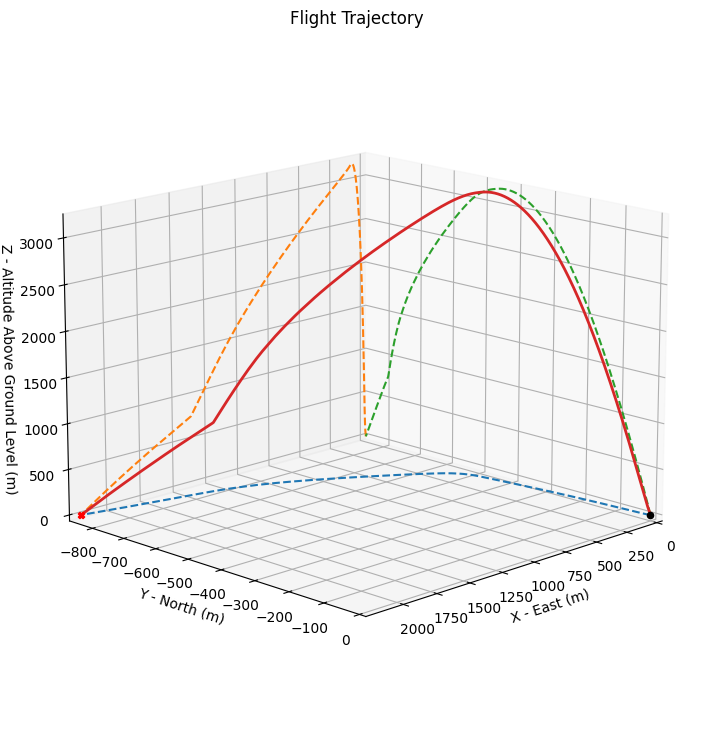

In [21]:
test_flight.plots.trajectory_3d()

The flight trajectory above represents the nominal trajectory of the rocket, without any uncertainties.

### Step 2: Starting the Monte Carlo Simulations


First, let's invoke the `MonteCarlo` class, we are going to need a filename to initialize it.
The filename will be used either to save the results of the simulations or to load them
from a previous ran simulation.


In [22]:
test_dispersion = MonteCarlo(
    filename="monte_carlo_analysis_outputs/monte_carlo_class_example",
    environment=mc_env,
    rocket=stochastic_rocket,
    flight=mc_flight,
)

The following input file was imported: monte_carlo_analysis_outputs/monte_carlo_class_example.inputs.txt
A total of 68 simulations results were loaded from the following output file: monte_carlo_analysis_outputs/monte_carlo_class_example.outputs.txt

The following error file was imported: monte_carlo_analysis_outputs/monte_carlo_class_example.errors.txt


C:\Users\guiga\Documents\github\RocketPy\rocketpy\simulation\monte_carlo.py:97: UserWarning: This class is still under testing and some attributes may be changed in next versions
  warnings.warn(


Finally, let's simulate our flights. 
We can run the simulations using the method `MonteCarlo.simulate()`.

Set `append=False` to overwrite the previous results, or `append=True` to add the new results to the previous ones.


In [23]:
test_dispersion.simulate(number_of_simulations=1000, append=False)

Completed 1000 iterations. Total CPU time: 1156.3 s. Total wall time: 1192.3 sme left: 0 s   
Saving results.
Results saved to monte_carlo_analysis_outputs/monte_carlo_class_example.outputs.txt


### Visualizing the results


Now we finally have the results of our Monte Carlo simulations loaded!
Let's play with them.


First, we can print numerical information regarding the results of the simulations.


In [24]:
# You only need to import results if you did not run the simulations
# test_dispersion.import_results()

In [25]:
test_dispersion.num_of_loaded_sims

1000

In [26]:
test_dispersion.prints.all()

Monte Carlo Simulation by RocketPy
Data Source:  monte_carlo_analysis_outputs/monte_carlo_class_example
Number of simulations:  1000
Results: 

                Parameter            Mean       Std. Dev.
------------------------------------------------------------
                  t_final         301.499          36.733
         out_of_rail_time           0.365           0.069
                   apogee        3328.017         642.054
     frontal_surface_wind           3.124           0.601
              apogee_time          25.530           2.258
     out_of_rail_velocity          23.974           2.447
                 y_impact         -27.552         182.345
          max_mach_number           3.467          82.721
                 apogee_y         461.361         143.719
                 apogee_x          59.817         119.884
          impact_velocity        -858.510       26967.017
     lateral_surface_wind          -3.573           1.008
                 x_impact        2217.929

Secondly, we can plot the results of the simulations.


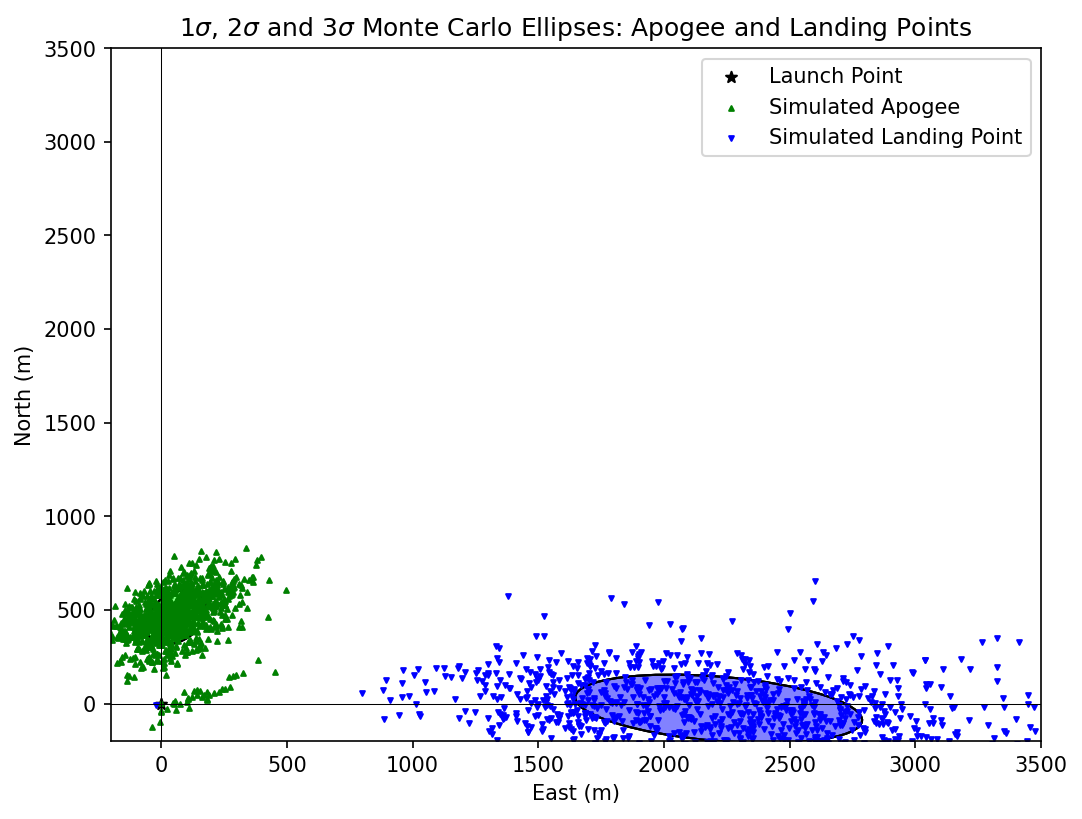

In [27]:
test_dispersion.plots.ellipses(xlim=(-200, 3500), ylim=(-200, 3500))

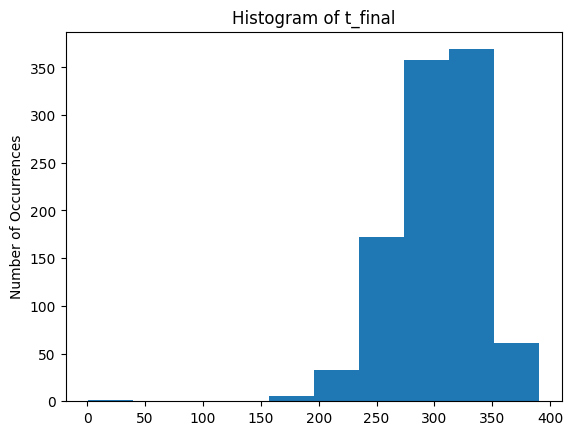

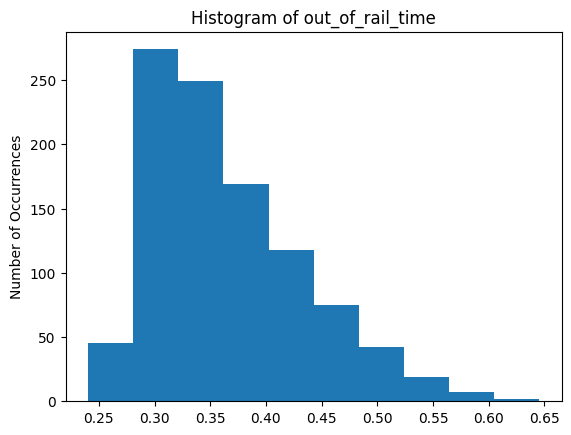

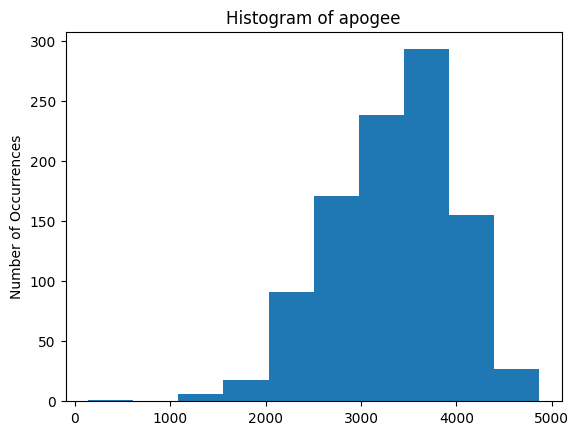

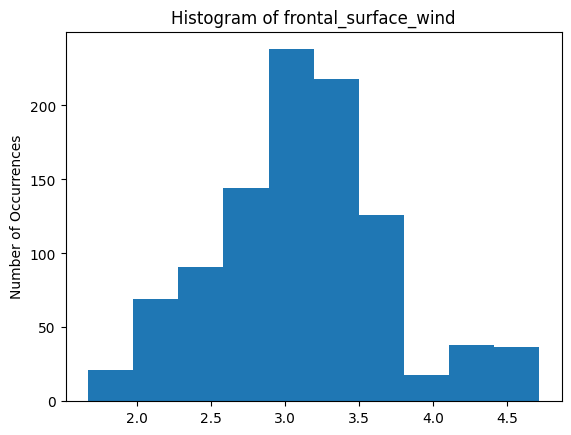

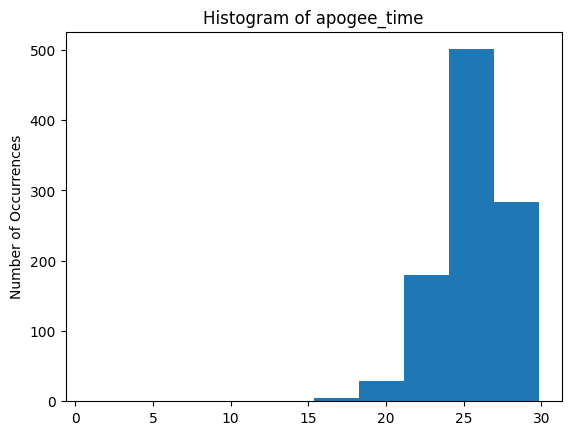

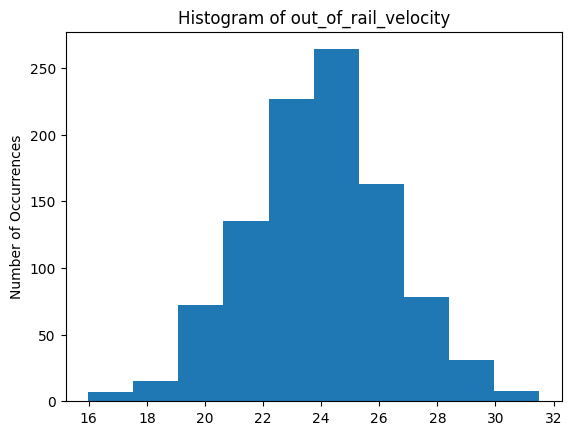

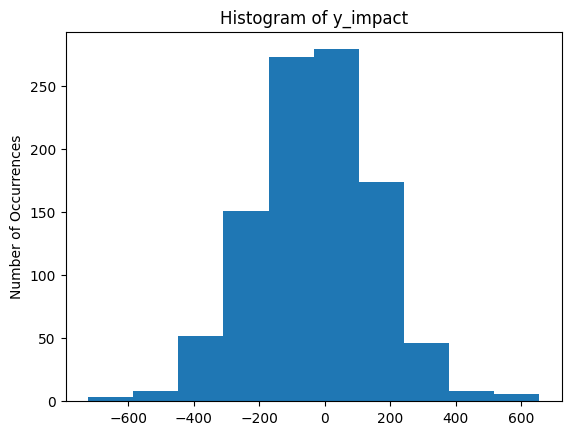

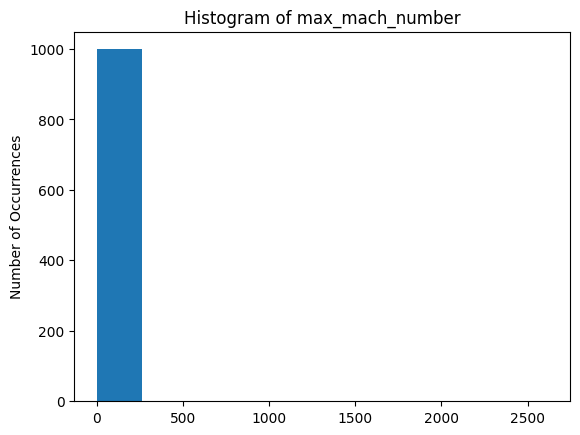

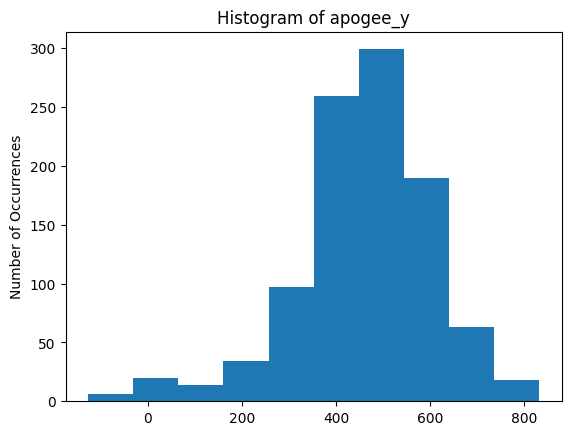

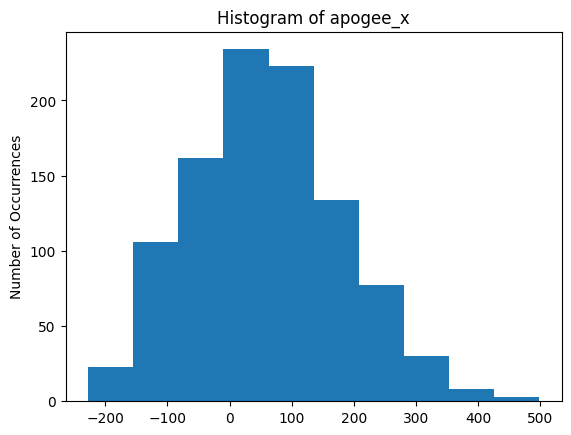

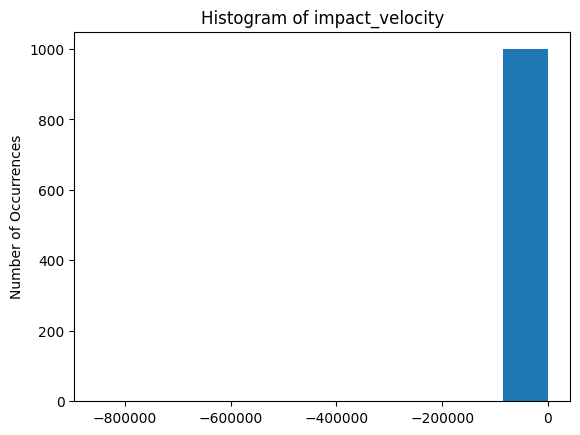

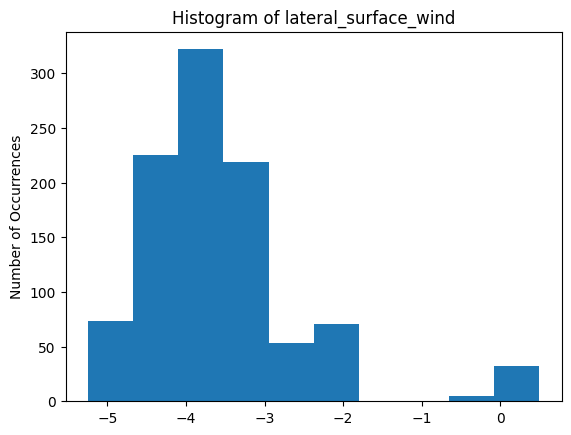

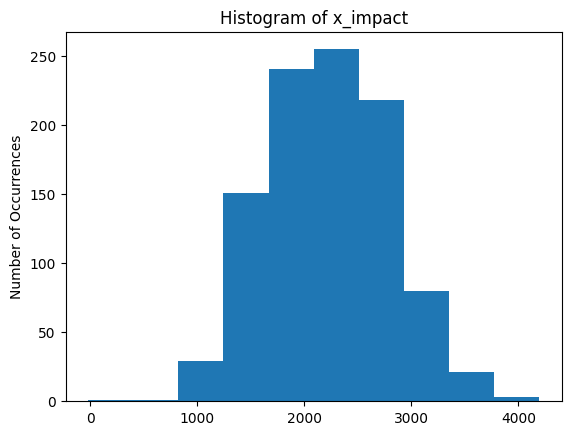

In [28]:
test_dispersion.plots.all()

Finally, one may also export the ellipses to a ``.kml`` file so it can be easily visualized in Google Earth


In [29]:
test_dispersion.export_ellipses_to_kml(
    filename="monte_carlo_analysis_outputs/monte_carlo_class_example.kml",
    origin_lat=env.latitude,
    origin_lon=env.longitude,
    type="impact",
)